In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import OrderedDict
import matplotlib.pyplot as plt

from scipy import interp

import warnings
import seaborn as sns
sns.despine()

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import binarize

from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit

from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree

import sys
sys.path.append('../scripts')
from helper_functions import *

### Load Funsite-PPI training and validation datasets

In [2]:
training_data_ML = pd.read_csv('../datasets/PPI/PPI_training_dataset.csv')
validation_data_ML = pd.read_csv('../datasets/PPI/PPI_validation_dataset.csv')

#### Define Features to use in the PPI model

In [3]:
features_ff = ['scons','avg_scons','sc5_gs','sc5_scons', 'conserved_hotspot_struc_neighbourhood', 'conserved_surface_hotspot_struc_neighbourhood', 'highly_conserved_struc_neighbourhood', 'highly_conserved_surface_struc_neighbourhood', 'pocket_conserved_struc_neighbourhood', 'pocket_surface_conserved_struc_neighbourhood',
               'avg_charged', 'avg_cx', 'avg_dpx', 'avg_electric_effect', 'avg_flexibility', 'avg_hydropathicity', 'avg_hydrophobicity', 'avg_polarity', 'avg_surface_residues', 'avg_surrounding_hydrophobicity', 'dist_to_hotspot', 'dist_to_surface', 'hotspot_struc_neighbourhood', 'pocket_struc_neighbourhood', 'surface_residues_struc_neighbourhood', 'min_dist_to_cleft123', 'min_dist_to_cleft_1', 'min_dist_to_cleft_2', 'min_dist_to_cleft_3', 'surface_residue_rsa', 'cleft_residue', 'hydrophobic_aa', 'polar_aa',
               'alpha','betweenness','bulkiness','charge','cleft_depth','cleft_num','closeness','degree','foldx_alascan','free_energy_solution','hydration_potential','hydropathicity','hydropathy_index','hydrophobicity','hydrophobicity_psaia','kappa','localised_electrical_effect','max_cx','max_dpx','min_cx','min_dpx','nhBonds_ptr','oBonds_ptr','phi','polarity','psi','resTco','res_bfactor_n','rsa_allatoms','rsa_mainchain','rsa_nonpolar','rsa_polar','rsa_totside','van_der_waals_vol_normalised',
               'dssp_type_B','dssp_type_H','dssp_type_NO_PRED','dssp_type_T',
               'A_pssm_ff','A_wop_ff','C_pssm_ff','C_wop_ff','D_pssm_ff','D_wop_ff','E_pssm_ff','E_wop_ff','F_pssm_ff','F_wop_ff','G_pssm_ff','G_wop_ff','H_pssm_ff','H_wop_ff','I_pssm_ff','I_wop_ff','K_pssm_ff','K_wop_ff','L_pssm_ff','L_wop_ff','M_pssm_ff','M_wop_ff','N_pssm_ff','N_wop_ff','P_pssm_ff','P_wop_ff','Q_pssm_ff','Q_wop_ff','R_pssm_ff','R_wop_ff','S_pssm_ff','S_wop_ff','T_pssm_ff','T_wop_ff','V_pssm_ff','V_wop_ff','W_pssm_ff','W_wop_ff','Y_pssm_ff','Y_wop_ff','gapless_match_to_pseudocounts_ff','info_per_pos_ff',
              ]

features_generic = [
               'bulkiness','charge','cleft_depth','cleft_num','hydration_potential','hydropathicity','hydropathy_index','hydrophobicity','localised_electrical_effect','max_cx','max_dpx','min_cx','min_dpx','mutability','polarity','psi','resTco','res_bfactor_n','rsa_allatoms','van_der_waals_vol_normalised','dssp_type_B','dssp_type_H','dssp_type_NO_PRED','dssp_type_T',
               'residue_aa_A','residue_aa_C','residue_aa_D','residue_aa_E','residue_aa_F','residue_aa_G','residue_aa_H','residue_aa_I','residue_aa_K','residue_aa_L','residue_aa_M','residue_aa_N','residue_aa_P','residue_aa_Q','residue_aa_R','residue_aa_S','residue_aa_T','residue_aa_V','residue_aa_W','residue_aa_Y',
               'A_pssm_psiblast','A_wop_psiblast','C_pssm_psiblast','C_wop_psiblast','D_pssm_psiblast','D_wop_psiblast','E_pssm_psiblast','E_wop_psiblast','F_pssm_psiblast','F_wop_psiblast','G_pssm_psiblast','G_wop_psiblast','H_pssm_psiblast','H_wop_psiblast','I_pssm_psiblast','I_wop_psiblast','S_pssm_psiblast','K_pssm_psiblast','K_wop_psiblast','L_pssm_psiblast','L_wop_psiblast','M_pssm_psiblast','M_wop_psiblast','R_wop_psiblast','N_pssm_psiblast','N_wop_psiblast','P_pssm_psiblast','P_wop_psiblast','Q_pssm_psiblast','Q_wop_psiblast','R_pssm_psiblast','S_wop_psiblast','T_pssm_psiblast','T_wop_psiblast','V_pssm_psiblast','V_wop_psiblast','Y_wop_psiblast','Y_pssm_psiblast','W_wop_psiblast','W_pssm_psiblast','info_per_pos_psiblast','gapless_match_to_pseudocounts_psiblast','entwop_score_psiblast',        
              ]

In [4]:
X_ff = training_data_ML[features_ff]
X_generic = training_data_ML[features_generic]

y = training_data_ML['annotation_IBIS_PPI_INTERCHAIN']

In [5]:
def get_pr_curve_model_pred_dataset(X, y, groups):
    
    y_real=[]
    y_proba=[]
    
    i = 0
    
    for train, test in group_kfold.split(X, y, groups):
        
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_test = X.iloc[test]
        y_test = y.iloc[test]

        classifier = XGBClassifier(

            n_estimators = 1000,
            learning_rate = 0.01,
            subsample = 0.8,
            colsample_bytree = 0.8,
            max_depth=7, 
            gamma=1,
            reg_apha=1,
            objective = 'binary:logistic',
            scale_pos_weight = 4,
            njobs=-1,

        )
        
        classifier.fit(X_train, y_train)
        
        pred_proba = classifier.predict_proba(X_test)
        precision, recall, thresholds = precision_recall_curve(y_test, pred_proba[:, 1])
        y_real.append(y_test)
        y_proba.append(pred_proba[:,1])

        i += 1
        
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    precision_overall, recall_overall, _ = precision_recall_curve(y_real, y_proba)
    pr_auc_overall = auc(recall, precision)
        
    return (precision_overall, recall_overall, pr_auc_overall)

In [6]:
domgroups = training_data_ML['domain'].tolist()
groups = domgroups

group_kfold = GroupKFold(n_splits=5)

precision_ff, recall_ff, pr_auc_ff = get_pr_curve_model_pred_dataset(X_ff, y, groups)
precision_generic, recall_generic, pr_auc_generic = get_pr_curve_model_pred_dataset(X_generic, y, groups)

label_ff = 'FunSite-PPI (PR AUC=%.3f)' % (pr_auc_ff)
label_generic = 'Generic-PPI (PR AUC=%.3f)' % (pr_auc_generic)

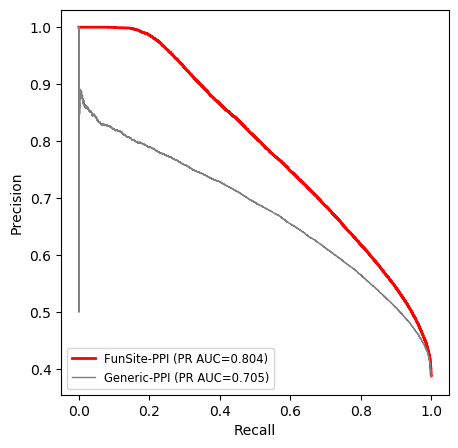

In [7]:
label_ff = 'FunSite-PPI (PR AUC=%.3f)' % (pr_auc_ff)
label_generic = 'Generic-PPI (PR AUC=%.3f)' % (pr_auc_generic)

plt.rcdefaults()
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['axes.facecolor']='white'

plt.plot(recall_ff, precision_ff, label=label_ff, lw=2, color='red')
plt.plot(recall_generic, precision_generic, label=label_generic, lw=1, color='grey')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left', fontsize='small')
#plt.savefig('PPI-ibis_interchain_vs_generic.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
xmodel_ff = XGBClassifier(
            n_estimators = 1000,
            learning_rate = 0.01,
            subsample = 0.8,
            colsample_bytree = 0.8,
            max_depth=7, 
            gamma=1,
            reg_apha=1,
            objective = 'binary:logistic',
            scale_pos_weight = 4,
            njobs=-1,
    
)

xmodel_gen = XGBClassifier(

            n_estimators = 1000,
            learning_rate = 0.01,
            subsample = 0.8,
            colsample_bytree = 0.8,
            max_depth=7, 
            gamma=1,
            reg_apha=1,
            objective = 'binary:logistic',
            scale_pos_weight = 4,
            njobs=-1,
)

xmodel_ff.fit(X_ff, y)
xmodel_gen.fit(X_generic, y)

# Saving models with joblib
modelname = 'PPI_Funsite_model.sav'
joblib.dump(xmodel_ff, modelname)

['PPI_Funsite_model.sav']

### FunSite-PPI compared to other predictors on the PPI holdout set

In [9]:
X_val_funsite = validation_data_ML[features_ff]
X_val_generic = validation_data_ML[features_generic]

y_val = validation_data_ML['annotation_IBIS_PPI_INTERCHAIN']

validation_funsite_pred = xmodel_ff.predict_proba(X_val_funsite)[:, 1]
validation_generic_pred = xmodel_gen.predict_proba(X_val_generic)[:, 1]

precision_val_ff, recall_val_ff, thresholds_val_ff = precision_recall_curve(y_val,validation_funsite_pred)
precision_val_generic, recall_val_generic, thresholds_val_generic = precision_recall_curve(y_val,validation_generic_pred)
pr_auc_val_ff = auc(recall_val_ff, precision_val_ff)
pr_auc_val_generic = auc(recall_val_generic, precision_val_generic)

label_ff = 'FunSite-PPI (PR AUC=%.3f)' % (pr_auc_val_ff)
label_generic = 'Generic-PPI (PR AUC=%.3f)' % (pr_auc_val_generic)

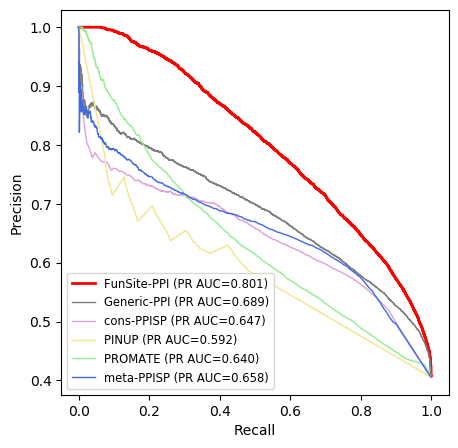

In [10]:
validation_cons_ppisp = validation_data_ML['cons_ppisp']
validation_pinup = validation_data_ML['pinup']
validation_promate = validation_data_ML['promate']
validation_meta_ppisp = validation_data_ML['meta_ppisp']
validation_meta_ppisp_predict = validation_data_ML['meta_predict']

precision_val_cons_ppisp, recall_val_cons_ppisp, thresholds_val_cons_ppisp = precision_recall_curve(y_val,validation_cons_ppisp)
precision_val_pinup, recall_val_pinup, thresholds_val_pinup = precision_recall_curve(y_val,validation_pinup)
precision_val_promate, recall_val_promate, thresholds_val_promate = precision_recall_curve(y_val,validation_promate)
precision_val_meta_ppisp, recall_val_meta_ppisp, thresholds_val_meta_ppisp = precision_recall_curve(y_val,validation_meta_ppisp)
precision_val_meta_ppisp_predict, recall_val_meta_ppisp_predict, thresholds_val_meta_ppisp_predict = precision_recall_curve(y_val,validation_meta_ppisp_predict)

pr_auc_val_cons_ppisp = auc(recall_val_cons_ppisp, precision_val_cons_ppisp)
pr_auc_val_pinup = auc(recall_val_pinup, precision_val_pinup)
pr_auc_val_promate = auc(recall_val_promate, precision_val_promate)
pr_auc_val_meta_ppisp = auc(recall_val_meta_ppisp, precision_val_meta_ppisp)
pr_auc_val_meta_ppisp_predict = auc(recall_val_meta_ppisp_predict, precision_val_meta_ppisp_predict)

label_cons_ppisp = 'cons-PPISP (PR AUC=%.3f)' % (pr_auc_val_cons_ppisp)
label_pinup = 'PINUP (PR AUC=%.3f)' % (pr_auc_val_pinup)
label_promate = 'PROMATE (PR AUC=%.3f)' % (pr_auc_val_promate)
label_meta_ppisp = 'meta-PPISP (PR AUC=%.3f)' % (pr_auc_val_meta_ppisp)
label_meta_ppisp_predict = 'meta-PPISP-predict (PR AUC=%.3f)' % (pr_auc_val_meta_ppisp_predict)

label_ff = 'FunSite-PPI (PR AUC=%.3f)' % (pr_auc_val_ff)
label_generic = 'Generic-PPI (PR AUC=%.3f)' % (pr_auc_val_generic)

plt.plot(recall_val_ff, precision_val_ff, label=label_ff, lw=2, color='red')
plt.plot(recall_val_generic, precision_val_generic, label=label_generic, lw=1, color='grey')

plt.plot(recall_val_cons_ppisp, precision_val_cons_ppisp, label=label_cons_ppisp, lw=1, color='plum')#
plt.plot(recall_val_pinup, precision_val_pinup,label=label_pinup,  lw=1, color='khaki')#
plt.plot(recall_val_promate, precision_val_promate, label=label_promate,  lw=1, color='lightgreen')#
plt.plot(recall_val_meta_ppisp, precision_val_meta_ppisp, label=label_meta_ppisp, lw=1, color='royalblue')
#plt.plot(recall_val_meta_ppisp_predict, precision_val_meta_ppisp_predict, label=label_meta_ppisp_predict, lw=1, color='blue')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(fontsize='small', loc='lower left')
#plt.savefig('PPI-IBIS_INTERCHAIN_vs_others_TEST.png', dpi=300, bbox_inches='tight')
plt.show()

(array([2738., 2052., 2217., 2714., 3358., 3963., 4376., 5025., 5758.,
        7939.]),
 array([0.00350665, 0.10308381, 0.20266096, 0.30223814, 0.4018153 ,
        0.5013924 , 0.6009696 , 0.70054674, 0.80012393, 0.89970106,
        0.99927825], dtype=float32),
 <a list of 10 Patch objects>)

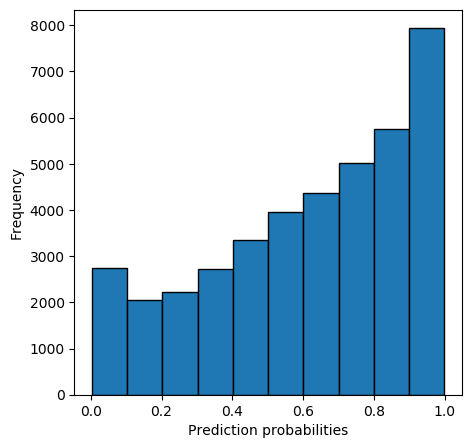

In [11]:
plt.xlabel('Prediction probabilities')
plt.ylabel('Frequency')

plt.hist(validation_funsite_pred, edgecolor='black', linewidth=1) 
#plt.savefig('PPI_validation_prediction_probabilities_hist.png', dpi=300, bbox_inches='tight')

In [ ]:
import sklearn
from sklearn import metrics
sorted(sklearn.metrics.SCORERS.keys())
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import fbeta_score, make_scorer

mcc_scorer = make_scorer(matthews_corrcoef)

xg_scores_ff = cross_validate(xmodel_ff, X_ff, y, groups, scoring=mcc_scorer, cv=GroupKFold(n_splits=5))
xg_scores_gen = cross_validate(xmodel_gen, X_generic, y, groups, scoring=mcc_scorer, cv=GroupKFold(n_splits=5))

diff_scores = ['roc_auc','accuracy', 'precision', 'recall', 'f1']

xg_scores_ff = cross_validate(xmodel_ff, X_ff, y, groups, scoring=diff_scores, cv=GroupKFold(n_splits=5))
xg_scores_gen = cross_validate(xmodel_gen, X_generic, y, groups, scoring=diff_scores, cv=GroupKFold(n_splits=5))

print('ROC_AUC:')
print('ff=',xg_scores_ff['test_roc_auc'].mean(), 'generic=', xg_scores_gen['test_roc_auc'].mean())

print('\nPrecision:')
print('ff=',xg_scores_ff['test_precision'].mean(),  'generic=', xg_scores_gen['test_precision'].mean())

print('\nRecall')
print('ff=',xg_scores_ff['test_recall'].mean(),  'generic=', xg_scores_gen['test_recall'].mean())

print('\nF1:')
print('ff=',xg_scores_ff['test_f1'].mean(),  'generic=', xg_scores_gen['test_f1'].mean())

print('\nAccuracy:')
print('ff=',xg_scores_ff['test_accuracy'].mean(), 'generic=', xg_scores_gen['test_accuracy'].mean())

#### Generate FunSite-PPI model without 175 domains for combined predictor

In [ ]:
domains175_list = ['3mddA03', '1itqA00', '1xa8A00', '1os7A00', '1oroA00', '1ct9A02', '1odtC00', '1qprA02', '1d4aA00', '1fdyA00', '1cjuA00', '1n0hB03', '1j21A01', '2hwgA03', '1zp3A00', '1fuqA02', '1arzA02', '1soxA02', '1b8gA02', '1v54A00', '1ordA02', '1qinA00', '1rm0A01', '3csmA00', '2qutA00', '2c3mA01', '1kwsA00', '1ct9A01', '1kqfC00', '1idtA00', '1dqsA02', '1rk2A00', '1mumA00', '1mt5A00', '1l8sA00', '1d8dB00', '1nvmA02', '1wgiA00', '1rypI00', '2ahjA00', '1psdA02', '1j49A02', '1dqsA01', '1grcA00', '1ivhA02', '1qsgA00', '1cb7B01', '1cjuB00', '1jm6A01', '1a50B02', '1cb7A00', '1afrA00', '1nbaA00', '2ag0B01', '1oasA01', '1j79A00', '1e19A00', '1dqaA03', '1oe8A01', '2gsaA02', '2ocpA00', '1hyoA02', '1d8hA00', '2qf7A04', '1h7xA05', '1gpmA02', '1ksjA00', '1gz6A01', '1f61A00', '2esdA02', '1pvdB01', '1x7dA02', '1b7yA00', '1rvvA00', '3ey9A03', '1hxqA02', '1cqjA02', '1apxA02', '1dtwA00', '1bmfD02', '1tkkA02', '1hy3A00', '1fuiA02', '1ndoE01', '1ycfA01', '1dtwB02', '1ey3A01', '4mdhA02', '1xldA00', '1qhfA00', '2qf7A02', '1u8vA03', '1l6gB02', '1fc4A01', '1uqtA02', '1dqaA02', '1trkB02', '1djoA01', '1n62B05', '1cl1A01', '1j21A02', '1reqA01', '2gh5B03', '1dekA02', '1nwwA00', '1bouB00', '1hrkA02', '12asA00', '1snnA00', '1bzyA00', '1iphA01', '1cf2P02', '1cevA00', '1trkA01', '1dqrA02', '1ybvA00', '1dxeA00', '1ozhA04', '1mroA02', '1fr8A00', '1mpyA02', '1oacA03', '1a05A00', '1dqrA01', '1gxsA00', '2cjaA02', '2pz0A00', '1bxrA02', '1rgqA02', '1dhfA00', '1n0hA01', '1n2cA02', '1dtyA02', '1rblA02', '1iydA02', '1pvdA03', '3ecaB02', '1b57A00', '1niaA01', '1gt7A00', '1l6gA01', '1nfsA00', '1n2cB01', '1imaA01', '1fuiA03', '1f2dA01', '1diiA04', '1oasA02', '1gzgA00', '1htoA01', '1hzzA01', '1b3rA01', '1jrpB04', '1do6A00', '2hdhA01', '1diiC00', '1p4rA04', '1alkA00', '1qfeA00', '1ec9A02', '1uaqA00', '1dbtA00', '1hr6B01', '1g64A00', '1g99A02', '1bd3A00', '1a50A00', '2ahjB01', '1aq0A00', '1sesA02', '1rozA00', '1i58A00', '1ndpB00', '1d8dA00', '1x9hA01']

ppidf_no175 = raw_feature_data[~raw_feature_data['domain'].isin(domains175_list)]
ppi = ppidf_no175[(ppidf_no175.annotation_IBIS_PPI_INTERCHAIN== 1) ]
ppi_doms = ppi.domain.unique()

nonppi = ppidf_no175[(ppidf_no175.annotation_IBIS_PPI_INTERCHAIN == 0 ) & ppidf_no175.domain.isin(ppi_doms)] 
nonppi['index']=nonppi['residue_string']
ppi['index']=ppi['residue_string']

ppidf_no175_trainML = preprocess_site_nonsite_df(ppi, nonppi, 4)
ppidf_no175_trainML.sort_values(['domain']).head(2)

X_no175 = ppidf_no175_trainML[features_ff]
y_no175 = ppidf_no175_trainML['annotation_IBIS_PPI_INTERCHAIN']

ppi_model_no175 = XGBClassifier(

    n_estimators = 1000,
            learning_rate = 0.01,
            subsample = 0.8,
            colsample_bytree = 0.8,
            max_depth=7, 
            gamma=1,
            reg_apha=1,
            objective = 'binary:logistic',
            scale_pos_weight = 4,
            njobs=-1,
)
ppi_model_no175.fit(X_no175, y_no175)

modelname = 'PPI_Funsite_xmodel_no175.sav'
joblib.dump(ppi_model_no175, modelname)